# Purpose

The overall goal of this exercise is to generate the billings for a grocery store/supermarket, so that we can create a recommendation system informed by customer purchases.

We start by defining some constrains: we will simulate the purchases of **100 customers** for **1 year**. We will use the following data (and all underlying assumptions that come with) related to grocery shopping habits:

 - H.1: The average person spends £26.5 per week on groceries (see https://www.nimblefins.co.uk/average-uk-household-cost-food), which obviously changes based on a person's caloric intake, or location, or any number of other factors
 - H.2: The average person does all of their shopping in one week, or when required (see https://yougov.co.uk/topics/food/articles-reports/2021/01/28/grocery-store-frequency-us-gb-poll); this varies by age group, but we'll assume that there is no variation.
 
and the following assumptions about customers:

 - C.1: They are all between the ages of 18 and 99. If we had a rewards program, like Tesco clubcard, adopting clients would have to be 18 years old or more.
 - C.2: Their shopping choices are not based on their sex.
 - C.3: Their shopping choices are not location dependent.

Additionally, we are making the following assumptions about the supermarket:

 - S.1: There is a constant stream of produce, so no shortages or supply chain problems. We don't want this to become supermarket simulator (at least not yet).
 - S.2: Prices are inelastic for the simulation year. This is obviously not the case, since there are always sales (and groceries have expiration dates, so they tend to be cheaper at the end of the day). However, we will assume no changes, since, again, this is not a supermarket simulator.
 
With this in mind, we now generate 100 customers! There are many ways we can generate our fake data: Faker (https://faker.readthedocs.io/en/master/) allows us to generate a variety of data points. Faker's `.profile()` might be a good place to start.

**ATTN**: Re-running this notebook will likely change some of the aggregate values below. Please read first!

In [15]:
from faker import Faker
from pprint import pprint

Faker.seed(42)

fake = Faker('en-GB')

In [17]:
for _ in range(3):
    pprint(fake.profile())
    print()

{'address': 'Flat 6\nMaria valley\nWest Sharon\nN9 1NW',
 'birthdate': datetime.date(2000, 10, 13),
 'blood_group': 'B-',
 'company': 'Thomas LLC',
 'current_location': (Decimal('36.349890'), Decimal('-60.581808')),
 'job': 'Planning and development surveyor',
 'mail': 'dorothy65@yahoo.co.uk',
 'name': 'Miss Marion Butler',
 'residence': '2 Amy burg\nLake Brett\nTR34 1RB',
 'sex': 'M',
 'ssn': 'ZZ 53 31 58 T',
 'username': 'coopermelissa',
 'website': ['https://wilson.com/',
             'https://taylor-morgan.com/',
             'https://robinson.com/',
             'https://www.hunt.biz/']}

{'address': '32 Parker gateway\nSouth Aaronmouth\nNG8W 7ZW',
 'birthdate': datetime.date(1927, 7, 22),
 'blood_group': 'B+',
 'company': 'Clarke, Burton and Singh',
 'current_location': (Decimal('-29.6984805'), Decimal('-73.092931')),
 'job': 'Hotel manager',
 'mail': 'jburke@yahoo.co.uk',
 'name': 'Mr. Damien Cooper',
 'residence': 'Flat 36Y\nHall mills\nNew Elaine\nDA1M 1JN',
 'sex': 'M',
 'ssn

As we can see, this allows us to generate a variery of data about a person. Upon observation, we get more information we need (birthdate), some information we can use in different contexts (e.g. job) and also some data is clearly problematic for other applications (e.g. some postal codes are just wrong).

We can use the basic output as a starting point, removing sex (see C.2) and residence/address (see C.3). 

### Customer ages

In [124]:
from datetime import datetime

customers = []

# Instead of generating 100 customers and removing the ones that do not conform to the 
# age constraint (see C.1), we generate customers until we have our 100.
while len(customers) <= 99:
    # We generate a fake customer
    profile = fake.profile()
    # We just care about their age; in the future, we may want to also keep birthdate,
    # allowing us to determine what products to offer our clients with a discount
    # on their birthday
    age = int((datetime.today().date() - profile['birthdate']).days/365.2425)
    
    if 18 < age < 99:
        customers.append({
            'age': age
        })

Let's have a look at the distrubution of the ages we generated. To facilitate visualisation, when we plot, let's bin the values in age ranges. We will just use standard measures (18-24, through to 55+), for simplicity.

In [120]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

In [121]:
age_ranges = [18, 25, 35, 45, 55, 99]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55+']

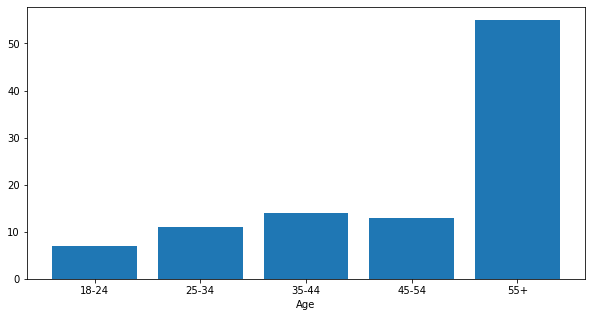

In [125]:
# We use Counter to count the number of bins
counter = Counter(
    np.digitize(
        sorted([cust['age'] for cust in customers]), # making sure the ages are sorted
        age_ranges  # the bin start and end
    )
)

# and matplotlib to plot
_, ax = plt.subplots(figsize=(10, 5))
ax.bar(counter.keys(), counter.values())
plt.xticks(range(1, len(counter)+1), age_labels)
ax.set_xlabel('Age')
plt.show()

Since we aggregated the data such that everyone 55+ is in one bin, it makes sense that the bar on the right is much higher. In reality, when we break down that particular category, we get a more sensible distribution (sensible, since we have no reason to think that the distribution of our clients skewers young or old):

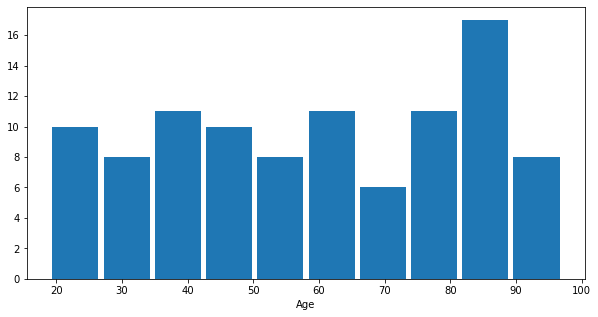

In [126]:
# and matplotlib to plot
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([cust['age'] for cust in customers], rwidth = 0.9)
ax.set_xlabel('Age')
plt.show()

### Shopping habits

Now, we determine whether our customers shop daily, weekly, or sporadically. Based on the data by YouGov (H.2), 48% of Brits does all of their shopping weekly, 3% does it daily, and 22% doesn't have a set routine. The data also reveals that 10% don't do grocery shopping at all!

Since we are assuming our 100 customers shop with us, we'll just re-adjust the percentages from the article.

In [136]:
# Daily, Weekly, monthly + as required (which we will treat as sporadic)
freq = [3, 48, 29+7+6]
new_freqs = np.array(freq) / sum(freq)
print(new_freqs)

[0.03225806 0.51612903 0.4516129 ]


We can use these frequencies to determine a customer habits.

In [139]:
for customer in customers:
    # Generate random number between 0 and 1
    rand = np.random.rand()
    if rand <= new_freqs[0]:
        customer['habit'] = 'daily'
    elif rand <= new_freqs[1]:
        customer['habit'] = 'weekly'
    else: customer['habit'] = 'sporadic'

In [140]:
pprint(Counter([cust['habit'] for cust in customers]))

Counter({'weekly': 50, 'sporadic': 47, 'daily': 3})


Good enough!

### Budget

Finally, we look at how much money a customer has to spend on a given trip to the supermarket. Given that the average person spends £26.50 per week (see H.1 and source), we can assign a budget of 26.5 to every customer whose habit is weekly, 26.5/7 $\approx$ 4 for customers whose habits are daily, and 26.5 x 52/12 $\approx$ 115 for customers who have sporadic shopping habits. The last figure is a monhtly budget, which we deduce from every time the customer goes to the shop!

In [141]:
for customer in customers:
    if customer['habit'] == 'daily':
        customer['budget'] = 4
    elif customer['habit'] == 'weekly':
        customer['budget'] = 26.5
    else: customer['budget'] = 115

In [142]:
pprint(customers)

[{'age': 24, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 84, 'budget': 115, 'habit': 'sporadic'},
 {'age': 82, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 75, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 69, 'budget': 115, 'habit': 'sporadic'},
 {'age': 52, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 90, 'budget': 115, 'habit': 'sporadic'},
 {'age': 21, 'budget': 115, 'habit': 'sporadic'},
 {'age': 26, 'budget': 115, 'habit': 'sporadic'},
 {'age': 84, 'budget': 115, 'habit': 'sporadic'},
 {'age': 20, 'budget': 4, 'habit': 'daily'},
 {'age': 30, 'budget': 115, 'habit': 'sporadic'},
 {'age': 85, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 89, 'budget': 115, 'habit': 'sporadic'},
 {'age': 46, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 79, 'budget': 115, 'habit': 'sporadic'},
 {'age': 83, 'budget': 115, 'habit': 'sporadic'},
 {'age': 92, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 85, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 54, 'budget': 26.5, 'habit': 'weekly'},
 {'age': 84, '

With this, we can save the customer's list (might be easier to save a JSON for portability) in preparation for the next step!

In [143]:
import json
json.dump(customers, open('../data/processed/customers.json', 'w'))